# Unsupervised Learning: dimensionality reduction

# Outline

1. [Recap: what is Unsupervised Learning](#recap)
2. [Measuring features](#features)
4. [Dimensionality reduction:motivation](#motivation)
5. [Principal component analysis](#pca)
6. [Kernel PCA](#kpca)
7. [t-Distributed Stochastic Neighbor Embedding ](#tsne)

In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy as sp
import sklearn.metrics as skmetrics

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

<a id="recap"></a>

## Recap: what is Unsupervised Learning

<div>
<img src="ml_types.png" width="500"/>
</div>

**Supervised learning**: discover patterns relating data attributes (descriptors, features) with a target (class) attribute $\rightarrow$ create a model. The model is used to predict the values of the target attribute in future data instances. 

**Unsupervised learning**: The data have no target attribute $\rightarrow$ we want to explore the data to find some intrinsic structures in them:
- Learn new features
- Learn groupings

Many example data sets and techniques provided by SciKit-Learn

<div>
<img src="sklogo.png" width="500"/>
</div>

<a id="features"></a>

## Measuring features

We use the terms _features_, _coordinates_, _attributes_ as synonims

We use the terms _distance_ or _dissimilarity_ as synonims and as the opposite of _similarity_

There are numerous distance functions for 
- Different types of data
    - Numeric data
    - Nominal data
- Different specific applications

### Numeric attributes

The most commonly used distances are the:
- $L_2$ norm, i. e. the Euclidean distance
- $L_1$ norm called also _cityblock_ or _Manhattan_ distance

$L_1$ and $L_2$ are a special case of _Minkowski_ distance where $h$ is positive integer:
$$ d(x_i,x_j) = \left( \sum_1^f (x_{if} - x_{jf}) \right)^{\frac{1}{h}}$$

$L_\infty$ norm called also _Chebyshev distance_ or _supremum distance_ and defined as 
$$ d(x_i, x_j) = max_{i,j}|x_i-x_j| $$

it is the limit of the above definition for $h\rightarrow\infty$; one wants to define two data points as "different" if they are different on any one of the attributes

Any definition of distance can be weighted:
$$ d(x_i,x_j) = \left( \sum_1^f w_f(x_{if} - x_{jf}) \right)^{\frac{1}{h}}$$

### Binary or nominal features

A binary attribute is _symmetric_ if both of its states (0 and 1) have equal importance, and carry the same weights, e.g., even or odd.  
**Simple matching function** proportion of mismatches of their values 
$$ dist(x_i, x_j) = \frac{b+c}{a+b+c+d}$$

Example:
$$ x_1 = (1,1,1,0,1,0,0)$$
$$ x_2 = (0,1,1,0,0,1,0)$$
$$d_{x_1,x_2} = \frac{2+1}{2+2+1+2} = \frac{3}{7} $$

### Jaccard coefficent

_Asymmetric_ attribute: if one of the states is more important or more valuable than the other. State 1 _usually_ represents the more important state, which is typically the rare or infrequent state. Jaccard coefficient:
$$ dist(x_i,x_j) = \frac{b+c}{a+b+c}$$

### Hamming distance

for two strings of equal length is the number mismatches in the same position:

$$ x_1 = (1,1,1,0,1,0,0) $$
$$ x_2 = (0,1,1,0,0,1,0) $$
$$d_{x_1,x_2} = 3 $$

### Mixed features

how can we compute the dissimilarity between objects of mixed attribute types?

simple approach: group each type of attribute together, performing separate data analysis for each type; unfeasible if the features are not distributed in a similar way

Unified distance:
$$ dist(x_i, x_j) = \frac{ \sum_{f=1}^h \delta_{ij}^{(f)}d_{ij}^{(f)}}{\sum_{f=1}^h \delta_{ij}^{(f)}}$$

where:
- $\delta_{ij}$ is 1 if $x_{if}$ or $x_{jf}$ are missing or are 0 for a _binary symmetric_ feature
- 1 otherwise  
in addition $d_{ij}$ is:
- numeric: $d_{ij}^{(f)} = \frac{|x_{if}-x_{jf}}{max x_f - min x_f}$
- nominal or binary: $d_{ij}^{(f)}$ if $x_{if}=x_{jf}$ otherwise 0

### Exercise

Write a function to calculate the Hamming distance

<div>
<img src="gears.png" width="500"/>
</div>

### Solution

In [2]:
def hamming(it1, it2):
    """Return the Hamming distance between equal-length iterables."""
    if len(it1) != len(it2):
        raise ValueError("Lengths must be equal!")
    ham = np.sum([item1 !=item2 for item1,item2 in zip(it1,it2)])
    return ham

In [3]:
x_1 = (1,1,1,0,1,0,0) 
x_2 = (0,1,1,0,0,1,0)
hamming(x_1,x_2)

3

<a id="motivation"></a>

## Dimensionality reduction: motivation

Data compression: 

Suppose we have a two variable data set like the one on the left:

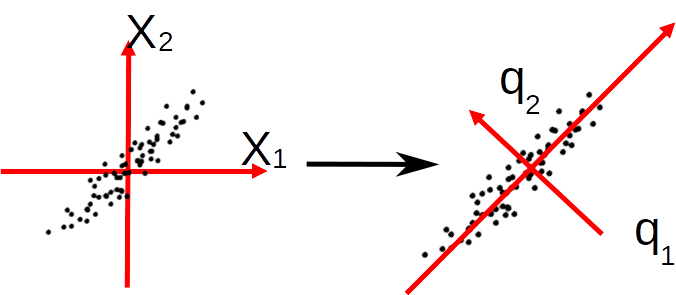

In [4]:
Image(filename="ellipsoid.svg.png")

We may want to rotate the laboratory axes to a new set $q1, q2$. Why? 

Using $x_1, x_2$ we see that both independent variables are important to locate a data point in space within an acceptable error. However, in the $q_1, q_2$ system $q_1$ would suffice.  
We have *reduced the dimensionality* of the system. Remember the *curse of dimensionality*

Data visualization:

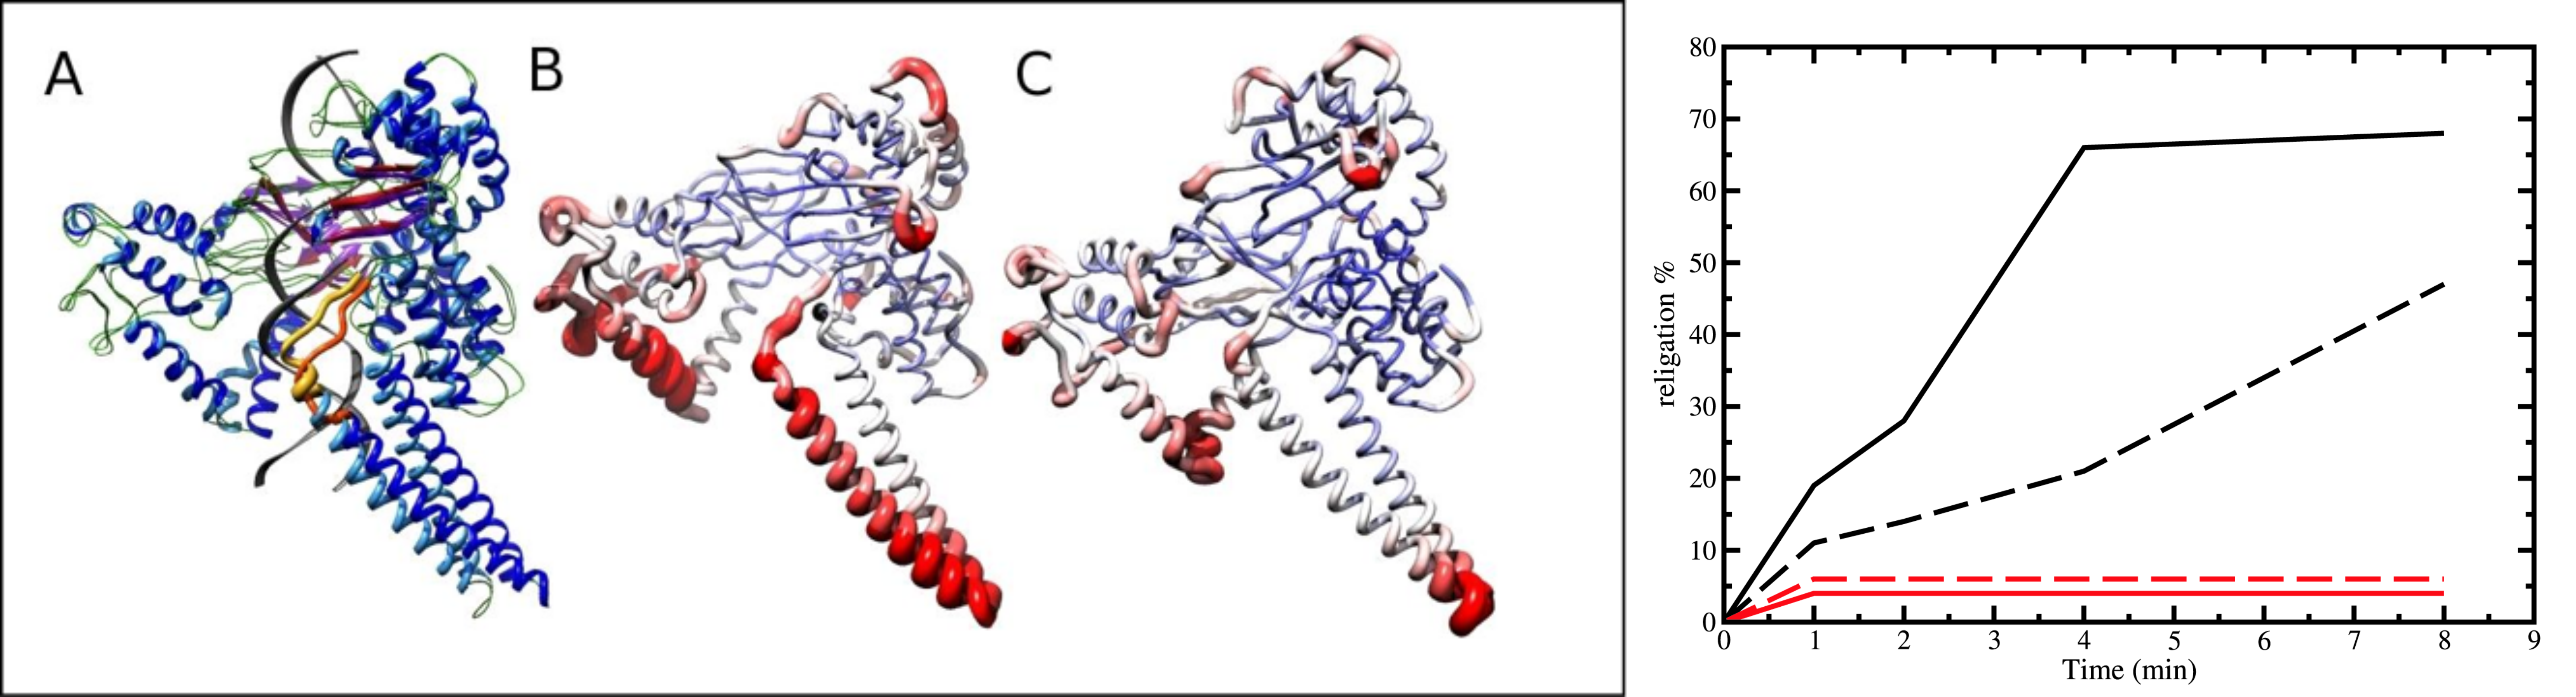

In [5]:
Image(filename="topo.png")

<a id="pca"></a>

## Principal component analysis

How can we measure the "amount of information" carried by $x_1$ or $x_2$ and decide how much to rotate the reference system? We can use their variance:
$$ var(x) = \frac{1}{N} \sum_{i=1}^N (x-\bar{x})^2 $$
A "useful rotation" would move part of the variance of $x2$ to $x1$. In doing this we also reduce the covariance between $x1$ and $x2$: 
$$cov(x1,x2) = (x1-\bar{x1})(x2-\bar{x2})$$

For n independent variables we can calculate the (symmetric) covariance matrix with elements $\Sigma_{ij} = cov(x_i,x_j)$. A good strategy would be then to have *uncorrelated* variables, e.g. by diagonalizing $\Sigma$: 
$$ U^{-1}\Sigma U = (\lambda_1, \lambda_2, \ldots, \lambda_n)$$ 
The eigenvalues $\lambda_i$ will the include the *amount of variance explained* by each eigenvector $U_i$.  

In [6]:
npoints = int(1e5)
a = 0.8
b = 0.1
#ellipse centered in .0, .0
x = 4*np.random.rand(npoints)-2.
y = 4*np.random.rand(npoints)-2.
r = (7*x)**2+(3*y)**2
sample = r <= 1. + 2*np.random.rand(npoints)
#rotation of the axes
alpha = 45.*(np.pi/180.)
xprime = x[sample]*np.cos(alpha) + y[sample]*np.sin(alpha)
yprime = -x[sample]*np.sin(alpha) + y[sample]*np.cos(alpha)

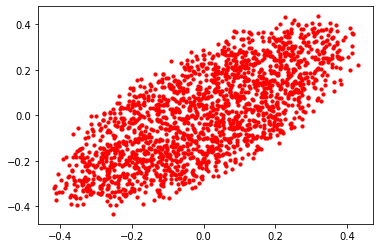

In [7]:
plt.scatter(xprime,yprime,marker='o',s=10,color='r')

Ordinating the eigenvalues and choosing a number of them equals to project the data set on a subspace whose vectors are those correspoding to the highest explained variance. This is what __Principal Component Analysis__ (Pearson 1901, Hotelling 1933) does.

In [8]:
from sklearn.decomposition import PCA
data = np.vstack((xprime,yprime)).T
estimator = PCA(n_components=2)
estimator.fit(data)
print(estimator.explained_variance_ratio_,np.sum(estimator.explained_variance_ratio_))
print(estimator.components_)

[0.8562642 0.1437358] 1.0
[[ 0.70175232  0.712421  ]
 [-0.712421    0.70175232]]


Thus the $q1$ variable explains approximately 85% of the total variance. 

PCA is useful if data is contained in an ellipsoid; however if I have a 4D hypersphere:

In [9]:
npoints = int(1e5)
w = 2*np.random.rand(npoints)-1.
x = 2*np.random.rand(npoints)-1.
y = 2*np.random.rand(npoints)-1.
z = 2*np.random.rand(npoints)-1.
r = w**2 + x**2 + y**2 + z**2
inside = r<1.
data = np.vstack((w[inside],x[inside],y[inside],z[inside])).T
mypca = PCA(n_components=4)
mypca.fit(data)
print(mypca.explained_variance_ratio_,np.sum(mypca.explained_variance_ratio_))

[0.25288052 0.25200899 0.24877119 0.2463393 ] 1.0


### Example: Iris data set

<div>
<img src="Principal_tree_for_Iris_data_set.png" width="700"/>
</div>

In [10]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
Y = iris.target

Plot sepals vs petals:

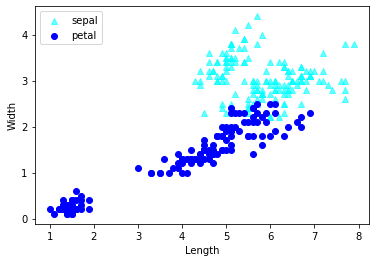

In [11]:
plt.scatter(X[:, 0], X[:, 1], c='cyan', marker='^',label="sepal",alpha=0.6,edgecolor=None)
plt.scatter(X[:, 2], X[:, 3], c='blue', marker='o',label="petal",edgecolor=None)
plt.xlabel('Length')
plt.ylabel('Width')
plt.legend()

Compare lenght and width

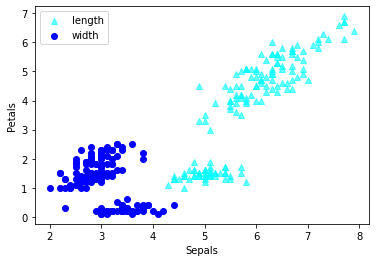

In [12]:
plt.scatter(X[:, 0], X[:, 2], c='cyan', marker='^',label="length",alpha=0.6)
plt.scatter(X[:, 1], X[:, 3], c='blue', marker='o',label="width")
plt.xlabel('Sepals')
plt.ylabel('Petals')
plt.legend()

Before trying PCA, apply _feature scaling_

In [13]:
import sklearn.preprocessing
from sklearn.decomposition import PCA
Xscaled = sklearn.preprocessing.scale(X)
np.mean(Xscaled),np.var(Xscaled),Xscaled.shape,X.shape

(-1.4684549872375404e-15, 1.0, (150, 4), (150, 4))

In [14]:
#create a pca instance
estimator = PCA(n_components=2)
estimator.fit(Xscaled)
X_2d = estimator.fit_transform(Xscaled)
print("Eigenvalues ",estimator.explained_variance_ratio_)
print("Eigenvectors ",estimator.components_)
print("Explained variance ",np.sum(estimator.explained_variance_ratio_))
print("New features",X_2d.shape)

Eigenvalues  [0.72962445 0.22850762]
Eigenvectors  [[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [ 0.37741762  0.92329566  0.02449161  0.06694199]]
Explained variance  0.9581320720000165
New features (150, 2)


the decomposition seems to be working; let's see how the flowers distribute along the PCs:

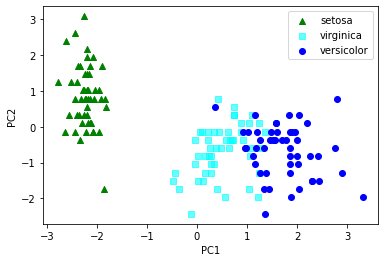

In [15]:
plt.scatter(X_2d[Y==0][:, 0], Xscaled[Y==0][:, 1], c='green', marker='^',label="setosa")
plt.scatter(X_2d[Y==1][:, 0], Xscaled[Y==1][:, 1], c='cyan', marker='s',label="virginica",alpha=0.6)
plt.scatter(X_2d[Y==2][:, 0], Xscaled[Y==1][:, 1], c='blue', marker='o',label="versicolor")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

### Exercise

Implement a numpy version of PCA and reconstruct an approximation of the original data iris data set from the PC

<div>
<img src="gears.png" width="500"/>
</div>

### Solution


In [16]:
from scipy.linalg import eigh
help(eigh)

Help on function eigh in module scipy.linalg.decomp:

eigh(a, b=None, lower=True, eigvals_only=False, overwrite_a=False, overwrite_b=False, turbo=True, eigvals=None, type=1, check_finite=True, subset_by_index=None, subset_by_value=None, driver=None)
    Solve a standard or generalized eigenvalue problem for a complex
    Hermitian or real symmetric matrix.
    
    Find eigenvalues array ``w`` and optionally eigenvectors array ``v`` of
    array ``a``, where ``b`` is positive definite such that for every
    eigenvalue λ (i-th entry of w) and its eigenvector ``vi`` (i-th column of
    ``v``) satisfies::
    
                      a @ vi = λ * b @ vi
        vi.conj().T @ a @ vi = λ
        vi.conj().T @ b @ vi = 1
    
    In the standard problem, ``b`` is assumed to be the identity matrix.
    
    Parameters
    ----------
    a : (M, M) array_like
        A complex Hermitian or real symmetric matrix whose eigenvalues and
        eigenvectors will be computed.
    b : (M, M) array_li

In [17]:
cov = np.cov(Xscaled.T)/Xscaled.shape[1]
print("cov shape", cov.shape)
myvals, myvecs = eigh(cov)
print(np.sum(myvals))
myvals = myvals[::-1][:2]
myvecs = myvecs.T[::-1][:2]
print(myvals.shape, myvecs.shape)
print(myvals)
print(myvecs)

cov shape (4, 4)
1.006711409395972
(2,) (2, 4)
[0.73452126 0.23004123]
[[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [-0.37741762 -0.92329566 -0.02449161 -0.06694199]]


In [18]:
print(X_2d.shape, (myvecs).shape, Xscaled.shape)
Xrec = np.dot(X_2d, myvecs)
print(np.var(Xrec)-np.sum(estimator.explained_variance_ratio_))

(150, 2) (2, 4) (150, 4)
1.7763568394002505e-15


### PCA vs Linear Regression

**not the same projections**

<div>
<img src="pca_vs_lr.jpeg" width="500"/>
</div>

### Example: dihedral PCA

Problem: MD simulations of a flexible chromophore, tyrosine. Six torsional degrees of freedom:

<div>
<img src="tyrosine.png" width="400"/>
</div>

Cartesian coordinates do not convey much information on the topology of a flexible molecule. What about using a _dihedral angles_?  
Angles are a periodic quantity with circular mean and variance. To deal with it transform from the space of dihedral angles $\phi_n$ to the coordinate space ${x_n=cos\phi_n,y_n=sin\phi_n}$  (see [here](#https://aip.scitation.org/doi/10.1063/1.2746330).)

In [19]:
dih_traj = np.loadtxt("dihedrals.dat")
dih_traj[:10]

array([[-107.475,  -66.147,    3.935,   66.31 ,  -54.5  ,   18.624],
       [-114.625,  -61.6  ,   -5.802,   75.414,  -70.24 ,   -1.611],
       [ -98.298,  -55.725,   17.769,   64.068,  -65.778,    6.477],
       [-142.168,  -74.425,    4.04 ,   54.909,  -67.441,    1.417],
       [-124.6  ,  -72.523,  -17.768,   50.227,  -57.1  ,  -11.357],
       [-155.604,  -64.068,  -17.56 ,   55.1  ,  -58.364,  -20.701],
       [-140.617,  -61.435,    3.72 ,   49.005,  -82.538,    4.522],
       [-171.321,  -74.027,   -1.862,   51.268,  -77.627,  -14.77 ],
       [-159.473,  -58.516,   -7.833,   51.632,  -70.928,    6.393],
       [ 178.378,  -37.398,   18.537,   39.383,  -60.463,   -6.354]])

In [20]:
n_frames=dih_traj.shape[0]
dih_tot=len(dih_traj[0,:])
print("number of frames ",n_frames)
print("number of dihedrals ", dih_tot)

number of frames  5847
number of dihedrals  6


In [21]:
sinv = np.sin(dih_traj*(np.pi/180.0))
cosv = np.cos(dih_traj*(np.pi/180.0))
Xd = np.empty((n_frames,2*dih_tot))
for i in range(n_frames):
    Xd[i] = np.vstack((cosv[i,:],sinv[i,:])).T.flatten() 

In [22]:
pca = PCA(n_components=12)
proj = pca.fit_transform(Xd)

In [23]:
print("DPCA eigenvalues and corresponding weight")
tot_var = 0
for i in range(len(pca.explained_variance_ratio_)):
    tot_var = tot_var +100*pca.explained_variance_ratio_[i]    
    print("%10.6f  %10.6f  %10.6f" %(pca.explained_variance_[i],\
                                           100*pca.explained_variance_ratio_[i],tot_var))

DPCA eigenvalues and corresponding weight
  0.940546   36.504586   36.504586
  0.655210   25.430073   61.934659
  0.331575   12.869124   74.803783
  0.200216    7.770809   82.574593
  0.141750    5.501606   88.076199
  0.112726    4.375151   92.451349
  0.088738    3.444107   95.895457
  0.050013    1.941114   97.836570
  0.037735    1.464561   99.301131
  0.015326    0.594846   99.895977
  0.001889    0.073317   99.969294
  0.000791    0.030706  100.000000


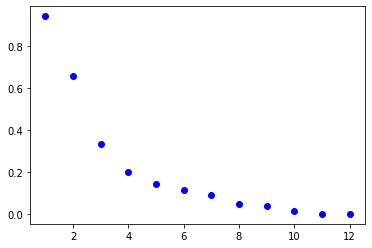

In [24]:
plt.plot((np.linspace(1,12,num=12,dtype='int')),pca.explained_variance_,'bo')

<div>
<img src="ivr2.png" width="800"/>
</div>

<a id="kpca"></a>

## Kernel PCA

PCA assumes that a linear boundary can be drawn

<div>
<img src="linear_vs_nonlinear.png" width="600"/>
</div>

### Higher dimensionality projection
basic idea: project linearly inseparable data onto a higher dimensional space where it becomes linearly separable. 

Suppose the decision boundary is described by a second order polynomial  as above: $y^2 = r^2 + bx^{2}$ . If we go to a higher dimensionality space in which the axes are $x,x^{2}, y$,  the circle becomes a linear function and the decision boundary becomes a hyperplane.

Direct projection on the higher dimension space is computationally costly. We assume the projection can be done withs nonlinear mapping function $\mathbf{k}$ so that the mapping of a sample $x$ can be written as $x\rightarrow\mathbf{k}(x)$. $\mathbf{k}$ is a _kernel function_.  
The _Kernel_ is the dot product of the images of the samples $x$ under $\mathbf{k}$:
$$ \mathbf{K}(\vec{x}_i,\vec{x}_j) = \mathbf{k}(\vec{x}_i)\mathbf{k}(\vec{x}_j)^T $$
where $\vec{x}_i \in R^d$, $\mathbf{k}(x_i)\in R^k$, $k>d$

$\mathbf{k}$ maps the original d features into k features which are nononlinear combinations of the original features. We assume that $\mathbf{K}$ yields the same result in the low dimension space.

Example:
$$ x=(x_1,x_2,x_3)^T $$
$$ f(x) = x^Tx $$
$$ f(x) = (x_1 x_1,x_1 x_2,x_1 x_3,x_2 x_1,x_2 x_2,x_2 x_3,x_3 x_1,x_3 x_2,x_3 x_3)^T$$

Suppose $x_i=x_j=(1,2,3)$  
**Direct** calculation in the high dimensional space is:  
$$f(x_i) * f(x_j)^T= [1, 2, 3, 2, 4, 6, 3, 6, 9] [1, 2, 3, 2, 4, 6, 3, 6, 9]^T =1 + 4 + 9 + 4 + 16 + 36 + 9 + 36 + 81 = 196$$
But $f(x_i) * f(x_j)^T = K(x_i,x_j) = (x_j^T,x_i)^2$ hence:
$$K(x_i,x_j) = ([1, 2, 3]^T [1, 2, 3])^2 = 14^2 = 196 $$

Not every projection to a higher space has an associated kernel function.

kernel methods is cheaper than direct projection but still intesive: you need the $R^{NxN}$ kernel matrix

### Gaussian kernel

One commonly used kernel is Gaussian Radial Basis Function (RBF) one:
$$ \mathbf{K}(x_i,x_j)= exp(−\gamma\lvert\lvert x_i−x_j\rvert\rvert^2) $$
where $\gamma=\frac{1}{2\sigma^2}$ is a parameter.

### KPCA step by step

PCA: we need to compute the complete variance-covariance matrix and diagonalize it:
$$ C =  \frac{1}{N}\sum_{i=1}^N \vec{x}_i\vec{x}_i^T$$
Kernel PCA: we would need to compute the covariance matrix in kernel space:
$$ C =  \frac{1}{N}\sum_{i=1}^N \mathbf{k}(\vec{x}_i)\mathbf{k}(\vec{x}_i)^T$$
instead we compute the *Kernel* matrix:
$$ K = \frac{1}{N} \sum _{i=1}^N \mathbf{K}(\vec{x}_i\vec{x}_i^T) $$
for a gaussian kernel:
$$ K_{ij} = exp(−\gamma\lvert\lvert \vec{x}_i−\vec{x}_j\rvert\rvert^2) $$

we do not obtain the principal components bu rather their _projections_

Since it is not guaranteed that the kernel matrix is centered, we can apply the following equation to do so:
$$ K^\prime = K−\mathbf{1}_N K - K\mathbf{1}_N + \mathbf{1}_N K\mathbf{1}_N $$

In [25]:
class simple_kpca:
    """
    Simple class for kernel PCA vaguely mimicking Sklearn API
    """
    def __init__(self,n_components, kernel="rbf"):
        """
        create an estimator of n components and choose kernel
        only rbf kernel currently supported
        """
        self.n_components = n_components
        if kernel != "rbf":
            raise NotImplemented
        else:
            self.kernel = "gaussian"
        
    def fit_transform(self, gamma, X):
        """
        Calculate Kernel matrix and diagonalize it
        Arguments: X: n points x m features input data set, gamma: 1/2 sigma^2
        """
        # squared distances, this is the argument of the kernel
        D2 = sp.spatial.distance.pdist(X, metric='sqeuclidean')
        D2 = sp.spatial.distance.squareform(D2)
        # compute K(x,xT)
        if self.kernel == "gaussian":
            K = np.exp(-gamma*D2)
        else:
            raise NotImplemented
        # apply centering
        N = K.shape[0]
        one_n = np.ones((N,N)) / N
        K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
        #solve eigenvalue problem; this are not "true" eigenvalues in k space
        #but rather their projections
        # eigenvalues in descending order 
        eigvals, eigvectors = eigh(K)
        eigvals = eigvals[::-1]
        eigvectors = eigvectors.T[::-1][:self.n_components]
        #eigvectors = np.column_stack((eigvectors[:,-i] for i in range(1,self.n_components+1)))
        return eigvectors.T

#### Swiss roll

In [26]:
from sklearn import manifold, datasets

n_points = 800
swiss_roll, color = datasets.make_s_curve(n_points, random_state=123)
n_components = 2

# PCA
pca = PCA(n_components=2)
swiss_pca = pca.fit_transform(swiss_roll)

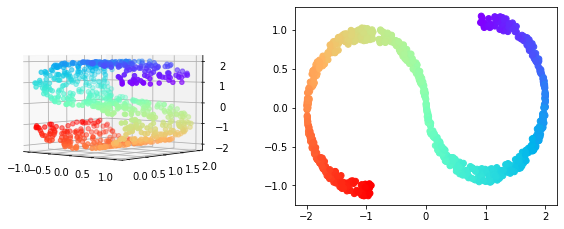

In [49]:
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(231, projection="3d")
ax.scatter(swiss_roll[:, 0], swiss_roll[:, 1], swiss_roll[:, 2], c=color, cmap=plt.cm.rainbow)
ax.view_init(3, -50)

ax = fig.add_subplot(232)
ax.scatter(swiss_pca[:, 0], swiss_pca[:, 1], c=color, cmap=plt.cm.rainbow)

(800, 2)


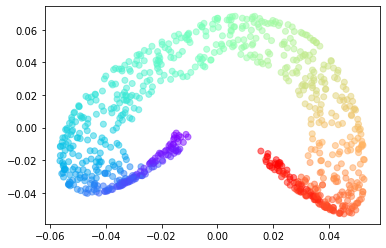

In [48]:
kpca = simple_kpca(n_components=2)
swiss_kpca = kpca.fit_transform(0.75, swiss_roll)
swiss_kpca = swiss_kpca
print(swiss_kpca.shape)
plt.scatter(swiss_kpca[:, 0], swiss_kpca[:, 1],  c=color,cmap=plt.cm.rainbow, alpha=0.5)

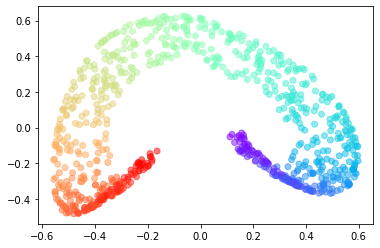

In [47]:
from sklearn.decomposition import KernelPCA
scikit_kpca = KernelPCA(n_components=2, kernel='rbf', gamma=0.75)
swiss_sk_kpca = scikit_kpca.fit_transform(swiss_roll)
plt.scatter(swiss_sk_kpca[:, 0], swiss_sk_kpca[:, 1], c=color, cmap=plt.cm.rainbow, alpha=0.5)

<a id="tsne"></a>

## t-Distributed Stochastic Neighbor Embedding (tSNE)

t-SNE ( Laurens van der Maatens and Geoffrey Hinton, Journal of Machine Learning Research 9(2008) 2579-2605)is an _unsupervised_, _non-linear_ technique used to explore and visualize _high dimensional data_. 

PCA seeks to maximize variance and pairwise distances hence objects that are _not near_ in the complete space end up _far apart_ in the reduced space. Not always the best for visualization (we may be interested in neighbourhood properties).

t-SNE preserves _only small pairwise distances_ or _local similarities_. Example from the original paper:

In [30]:
#tSNE
tsne = manifold.TSNE(n_components=2, init="pca", random_state=0)
swiss_tsne = tsne.fit_transform(swiss_roll)

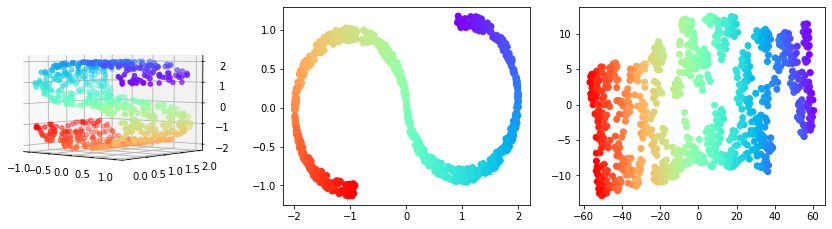

In [46]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_subplot(231, projection="3d")
ax.scatter(swiss_roll[:, 0], swiss_roll[:, 1], swiss_roll[:, 2], c=color, cmap=plt.cm.rainbow)
ax.view_init(3, -50)

ax = fig.add_subplot(232)
ax.scatter(swiss_pca[:, 0], swiss_pca[:, 1], c=color, cmap=plt.cm.rainbow)

ax = fig.add_subplot(233)
ax.scatter(swiss_tsne[:, 0], swiss_tsne[:, 1], c=color, cmap=plt.cm.rainbow)

Distance:
> tSNE starts by calculating the probability of similarity of points in high-dimensional in the corresponding low-dimensional space. Similarity is calculated as the conditional probability $x_i$ would choose $x_j$ as its neighbour if the underlying distribution is a Normal centered in $x_i$

Minimization
> It minimizes the difference between these conditional probabilities in higher-dimensional and lower-dimensional space for a perfect representation of data points in lower-dimensional space.
To measure the minimization of the sum of difference of conditional probability t-SNE minimizes the sum of **Kullback-Leibler divergence** of overall data points using a gradient descent method.

**KL divergence** is a measure of how one probability distribution diverges from a second, expected probability distribution

Original input features _are no longer identifiable_, you _cannot_ build back a reconstructed data set. Is mainly for **visualization**.

The join probability distribution in the hgh dimensional space is:
$$ x_{ij} = \frac{x_{i|j}+x_{j|i}}{2n}$$

where
$$x_{j|i} = \frac{exp(-\lvert\lvert x_j-x_i\rvert\rvert^2)/2\sigma_i^2}{\sum_{k\ne j}exp(-\lvert\lvert x_k-x_j\rvert\rvert^2)/2\sigma_i^2}$$

The name "t Distributed" comes form the fact the distribution in the embedded space is:
$$ xe_{ij} = \frac{1+\lvert\lvert xe_j-xe_i\rvert\rvert^2)}{\sum_{k\ne j}1+\lvert\lvert xe_k-xe_j\rvert\rvert^2)}$$

and the cost to minimize is:

$$ KL(P_{full},P_{emb}) = \sum_{i\ne j}x_{ij}\frac{xe_{ij}}{x_{ij}} $$

tSNE advantages:
- effective for embedding large dimensionality in 2D or 3D
- does not accumulate points in the center from high dimensional data (as PCA does)

tSNE weaknesses:
- computationally expensive, involves minimizing a cost function
- stochastic: multiple runs starts with different seeds yield different results (also conbined with minimization)
However, it is perfectly legitimate to pick the embedding with the least error.

## Exercise

The file `asp_LH_test.data.xz` contains a [Pandas data frame](#https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) which includes the results of a Potential Energy Surface of aspartic acid in gas phase carried out with EAs (see [here](#http://aip.scitation.org/doi/10.1063/5.0018314).

<div>
<img src="asp.png" width="500"/>
</div>

The data set is accessed in this way

In [32]:
import pandas as pd
asp_pes = pd.read_pickle("asp_LH_test.data.xz")
asp_pes.head()

(0, 3)     (3, 12)    (12, 14)      (3, 5)      (5, 8)     (8, 10)  \
0  -36.464000   14.538004 -176.916996  174.520995   -9.233997  179.186007   
1  -64.394064  -19.277872  -29.992921  171.892692 -169.747760   96.582077   
2  154.179123  168.436125 -125.606716  -72.657355  -43.874405 -171.043016   
3 -107.334178  -40.115131 -144.561949 -153.707466   55.440619   31.059754   
4 -132.371479  115.018847   90.234775   78.648060 -103.053836 -169.184848   

      energy                   filename  
0 -31.327645  asp_LH_test_00001.out.bz2  
1 -31.277546  asp_LH_test_00002.out.bz2  
2 -31.305746  asp_LH_test_00003.out.bz2  
3 -31.288911  asp_LH_test_00004.out.bz2  
4 -31.298300  asp_LH_test_00005.out.bz2

You can get a numpy array of dihedrals and energy in this way:

In [33]:
RB = [(0, 3), (3, 12), (12, 14), (3, 5), (5, 8), (8, 10)]
dih = asp_pes[RB].to_numpy(dtype=float)
dih.shape

(4112, 6)

In [34]:
EN = asp_pes['energy']
EN.shape

(4112,)

In [35]:
Elow = EN[EN <= -31.3]
Elow

0      -31.327645
2      -31.305746
16     -31.313200
18     -31.301481
24     -31.303836
          ...    
4107   -31.327470
4108   -31.321409
4109   -31.315854
4110   -31.329286
4111   -31.326718
Name: energy, Length: 4008, dtype: object

What you have to do:
- convert energy from hartree to kJ/mol and calculate $\Delta E$with respect to the absolute minimum. See [Scipy physical constants](#https://docs.scipy.org/doc/scipy/reference/constants.html)  
- convert dihedrals in order to run DPCA and tSNE
- graphs results correlating the projected space to the energy
- which distance would you use to compare two points?
- are all points relevant?

<div>
<img src="gears.png" width="500"/>
</div>

### Solution

In [36]:
har2kjmol = sp.constants.physical_constants["Avogadro constant"][0]\
*sp.constants.physical_constants["Hartree energy"][0]/1000.
print(har2kjmol)
gem = np.argmin(asp_pes['energy'])
deltaE = har2kjmol*(EN - EN[gem])

2625.4996394798254


We can discard structures with zero weight:

In [37]:
deltaEF = deltaE[deltaE <= 30.].to_numpy(dtype=float)
deltaEF

array([13.08030945, 10.10296292, 14.37034771, ..., 29.45272538,
        8.77065567, 15.51237249])

In [38]:
dih = asp_pes[RB]
dihF = dih[deltaE <= 30.].to_numpy(dtype=float)

In [39]:
deg2rad = np.pi/180.
s = np.sin(dihF*deg2rad)
c = np.cos(dihF*deg2rad)
v   = np.empty((dihF.shape[0], 2*dihF.shape[1]))
for i in range(dihF.shape[0]):
    v[i] = np.vstack((c[i,:],s[i,:])).T.flatten()

In [40]:
pca = PCA(n_components = 6)
dpca = pca.fit_transform(v)
print("DPCA eigenvalues and corresponding weight")
tot_var = 0
for i in range(len(pca.explained_variance_ratio_)):
    tot_var = tot_var +100*pca.explained_variance_ratio_[i]    
    print("%10.6f  %10.6f  %10.6f" %(pca.explained_variance_[i],\
                                           100*pca.explained_variance_ratio_[i],tot_var))

DPCA eigenvalues and corresponding weight
  0.899295   22.132174   22.132174
  0.562832   13.851637   35.983811
  0.465273   11.450648   47.434459
  0.434622   10.696303   58.130763
  0.396001    9.745824   67.876587
  0.342578    8.431048   76.307635


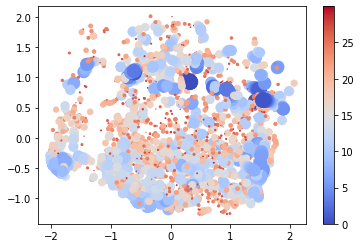

In [41]:
plt.scatter(dpca[:,0], dpca[:,1],c=deltaEF,cmap='coolwarm',s=(30.-deltaEF)**2/4)
plt.colorbar()

In [42]:
tsne = manifold.TSNE(n_components=2, init='pca')
tsne_results = tsne.fit_transform(v)

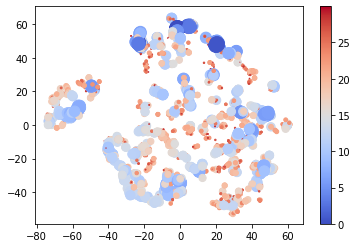

In [43]:
plt.scatter(tsne_results[:,0], tsne_results[:,1],c=deltaEF,cmap='coolwarm',s=(30-deltaEF)**2/4)
plt.colorbar()

## Other techniques
- Isomap
- Local Linear Embedding (LLE)
- Time Independent Component Analysis (TICA)
- Multidimensional Scaling (MDS)

## The End!